In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
samplemap = hp.read_map('/lustre/work/akira.tokiwa/Projects/LensingSSC/data/fullsky/bigbox/zs1.5/kappa_zs1.5_s104.fits')

In [34]:
from numpy.fft import fft2, fftshift
from scipy import signal
from scipy.fft import fft2, ifft2
from scipy.ndimage import gaussian_filter

In [17]:
xsize = 2048
padding = 0.1 + np.sqrt(2)
patch_size_deg = 5
resolution_arcmin = (patch_size_deg * 60.0) / xsize

samplepatch = hp.gnomview(
                samplemap,
                rot=[0, 0],
                xsize=xsize * padding,
                reso=resolution_arcmin,
                return_projected_map=True,
                nest=True,
                no_plot=True,
            )

epsilon = 0.26
pixelsize_deg = 10 / 2048 * 60
ngal = 30 # galaxies per square arcminute
noise_sigma = epsilon / np.sqrt(ngal * pixelsize_deg**2)

# Generate Gaussian noise
noise = np.random.normal(0, noise_sigma, samplepatch.shape)

# Add noise to the sample patch
noisy_samplepatch = samplepatch + noise

fft_samplepatch = fft2(samplepatch)
fft_samplepatch_shifted = fftshift(fft_samplepatch)

fft_noisy_samplepatch = fft2(noisy_samplepatch)
fft_noisy_samplepatch_shifted = fftshift(fft_noisy_samplepatch)


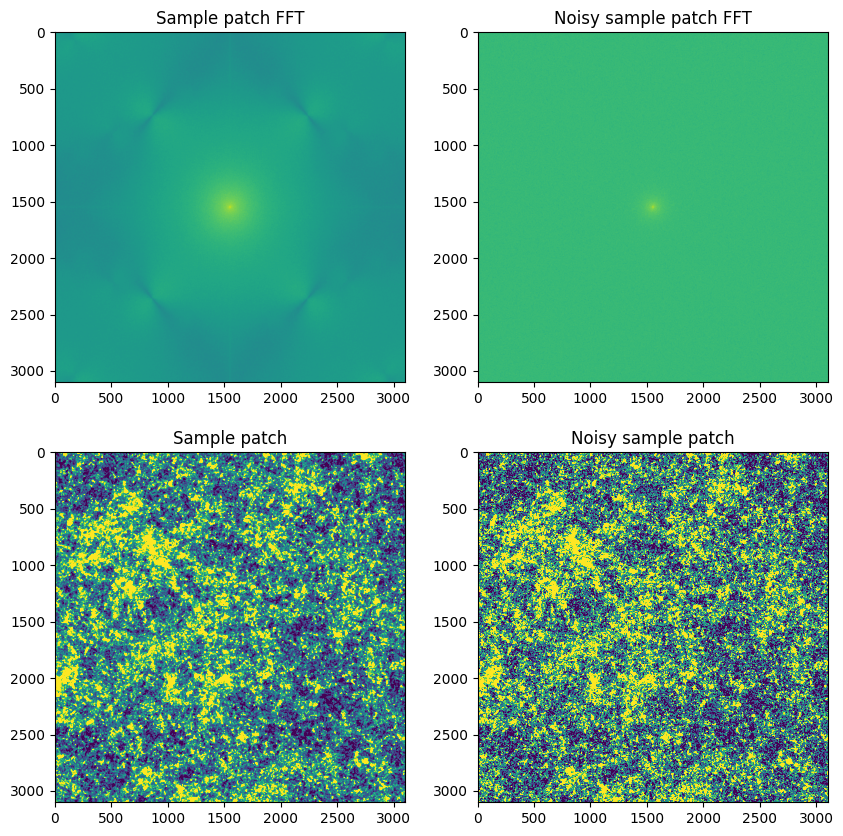

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(np.log10(np.abs(fft_samplepatch_shifted)), cmap='viridis')
ax[0, 0].set_title('Sample patch FFT')
ax[0, 1].imshow(np.log10(np.abs(fft_noisy_samplepatch_shifted)), cmap='viridis')
ax[0, 1].set_title('Noisy sample patch FFT')
ax[1, 0].imshow(samplepatch, cmap='viridis', vmin = -0.032, vmax = 0.032)
ax[1, 0].set_title('Sample patch')
ax[1, 1].imshow(noisy_samplepatch, cmap='viridis', vmin = -0.032, vmax = 0.032)
ax[1, 1].set_title('Noisy sample patch')
plt.show()

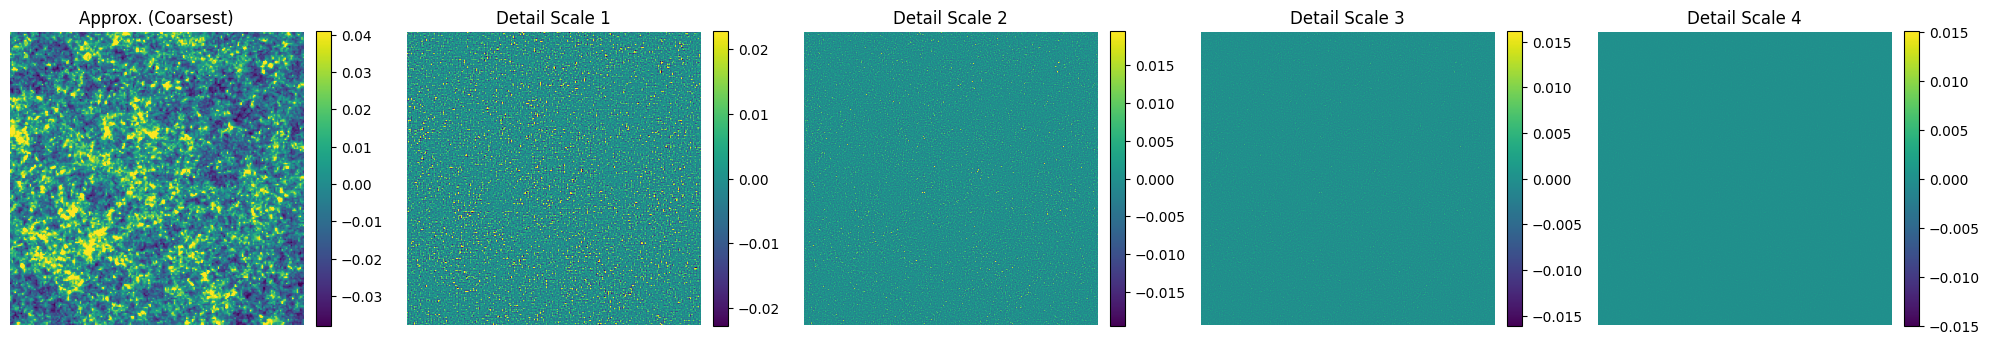

In [39]:
import pywt

# Choose a wavelet, e.g. 'haar' or 'db2'
wavelet_type = 'haar'
# Decide on the maximum level of decomposition
max_level = 4  # adjust as needed

# Perform wavelet decomposition
# coeffs is a list of arrays: 
#   coeffs[0] is the approximation coefficients at the highest scale (cA_n)
#   coeffs[1:] are the detail coefficients for each scale
coeffs = pywt.wavedec2(samplepatch, wavelet=wavelet_type, level=max_level)

# The approximation coefficients at the highest level
cA = coeffs[0]

# The detail coefficients at each level
detail_coeffs = coeffs[1:]  # list of tuples like (cH_i, cV_i, cD_i)

# Number of detail scales
num_scales = len(detail_coeffs)  # = max_level

# We'll store partial maps in a list for plotting
partial_maps = []

# (A) Approximation-Only Map (coarsest scale)
approx_only = [cA] + [(np.zeros_like(cH),
                       np.zeros_like(cV),
                       np.zeros_like(cD)) for (cH, cV, cD) in detail_coeffs]
map_approx_only = pywt.waverec2(approx_only, wavelet_type)
partial_maps.append(map_approx_only)

# (B) Maps for each detail scale (1 through num_scales)
for i in range(num_scales):
    # Create a copy of all coefficients, but zero out everything except the detail at scale i
    selective_coeffs = [np.zeros_like(cA)]  # zero out the approximation
    
    for scale_index, (cH, cV, cD) in enumerate(detail_coeffs):
        if scale_index == i:
            # Keep the original detail at this scale
            selective_coeffs.append((cH, cV, cD))
        else:
            # Zero out all other scales
            selective_coeffs.append((np.zeros_like(cH),
                                     np.zeros_like(cV),
                                     np.zeros_like(cD)))
    
    # Reconstruct partial map from these selective coefficients
    partial_map = pywt.waverec2(selective_coeffs, wavelet_type)
    partial_maps.append(partial_map)

# How many images we have
n_plots = len(partial_maps)  # 1 + num_scales

fig, axs = plt.subplots(1, n_plots, figsize=(4*n_plots, 4))

titles = ['Approx. (Coarsest)'] + [f'Detail Scale {i+1}' for i in range(num_scales)]

for ax, partial_map, title in zip(axs, partial_maps, titles):
    mean = np.mean(partial_map)
    std = np.std(partial_map)
    im = ax.imshow(partial_map, origin='lower', cmap='viridis', vmin=mean-2*std, vmax=mean+2*std)
    ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.axis('off')

plt.tight_layout()
plt.show()

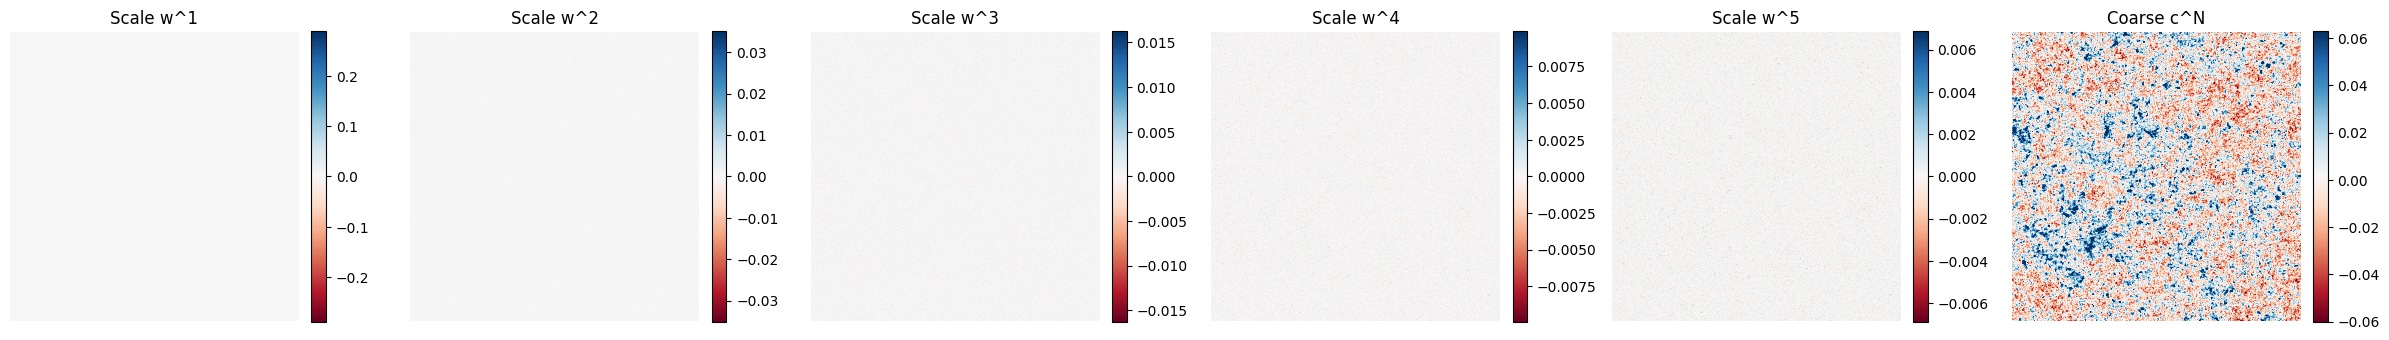

In [45]:
from scipy.ndimage import convolve
# -------------------------------------------------------------------------
# 2) DEFINE THE B3-SPLINE KERNEL
# -------------------------------------------------------------------------
# The standard one-dimensional B3-spline kernel for the starlet transform
b3_spline_1d = np.array([1, 4, 6, 4, 1], dtype=np.float32) / 16.0
# Create the 2D kernel via outer product
b3_spline_2d = np.outer(b3_spline_1d, b3_spline_1d)

# -------------------------------------------------------------------------
# 3) IMPLEMENT THE STARLET TRANSFORM
# -------------------------------------------------------------------------
def starlet_transform(image, n_scales=5):
    """
    Perform the starlet (à trous) transform on a 2D image.
    Returns a list of wavelet scales plus one final coarse scale.
      - wavelet_coeffs[0] : w^1 (finest scale)
      - wavelet_coeffs[1] : w^2
      - ...
      - wavelet_coeffs[n_scales-1] : w^n_scales
      - wavelet_coeffs[n_scales]   : c^n_scales (coarse scale)
    """
    wavelet_coeffs = []
    current_residual = image.copy()

    for _ in range(n_scales):
        # Smooth the current_residual by convolving with the B3-spline
        smooth = convolve(current_residual, b3_spline_2d, mode='reflect')
        # The wavelet scale is the difference between the residual and its smoothed version
        wavelet = current_residual - smooth
        wavelet_coeffs.append(wavelet)
        # Update the residual for the next scale
        current_residual = smooth

    # After n_scales iterations, 'current_residual' is the final coarse scale
    wavelet_coeffs.append(current_residual)
    return wavelet_coeffs

# -------------------------------------------------------------------------
# 4) DECOMPOSE THE KAPPA MAP
# -------------------------------------------------------------------------
n_scales = 5  # Number of wavelet scales you want
coeffs = starlet_transform(noisy_samplepatch, n_scales=n_scales)

# coeffs is a list of length n_scales + 1:
#   coeffs[0]   = w^1 (finest scale)
#   coeffs[1]   = w^2
#     ...
#   coeffs[-2]  = w^n_scales
#   coeffs[-1]  = c^n_scales (coarse scale)

# -------------------------------------------------------------------------
# 5) PLOT EACH WAVELET SCALE + THE COARSE SCALE
# -------------------------------------------------------------------------
fig, axs = plt.subplots(1, n_scales + 1, figsize=(4*(n_scales+1), 4))
scale_labels = [f'Scale w^{i+1}' for i in range(n_scales)] + ['Coarse c^N']

for ax, data, lbl in zip(axs, coeffs, scale_labels):
    mean = np.mean(data)
    std = np.std(data)
    im = ax.imshow(data, origin='lower', cmap='RdBu', vmin=mean-2*std, vmax=mean+2*std)
    ax.set_title(lbl)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# 6) (OPTIONAL) RECONSTRUCT THE ORIGINAL MAP
# -------------------------------------------------------------------------
def starlet_reconstruct(wavelet_coeffs):
    """
    Reconstruct an image from its starlet coefficients.
    wavelet_coeffs = [w^1, w^2, ..., w^N, c^N].
    The reconstruction is sum(w^j for j=1..N) + c^N.
    """
    # Sum all wavelet scales
    reconstructed = np.sum(wavelet_coeffs[:-1], axis=0)  
    # Add the final coarse scale
    reconstructed += wavelet_coeffs[-1]
    return reconstructed

In [44]:
# Reconstruct and confirm it matches the original (within floating precision):
kappa_reconstructed = starlet_reconstruct(coeffs)
print("Max absolute difference:", np.max(np.abs(kappa_reconstructed - noisy_samplepatch)))

Max absolute difference: 2.220446049250313e-16


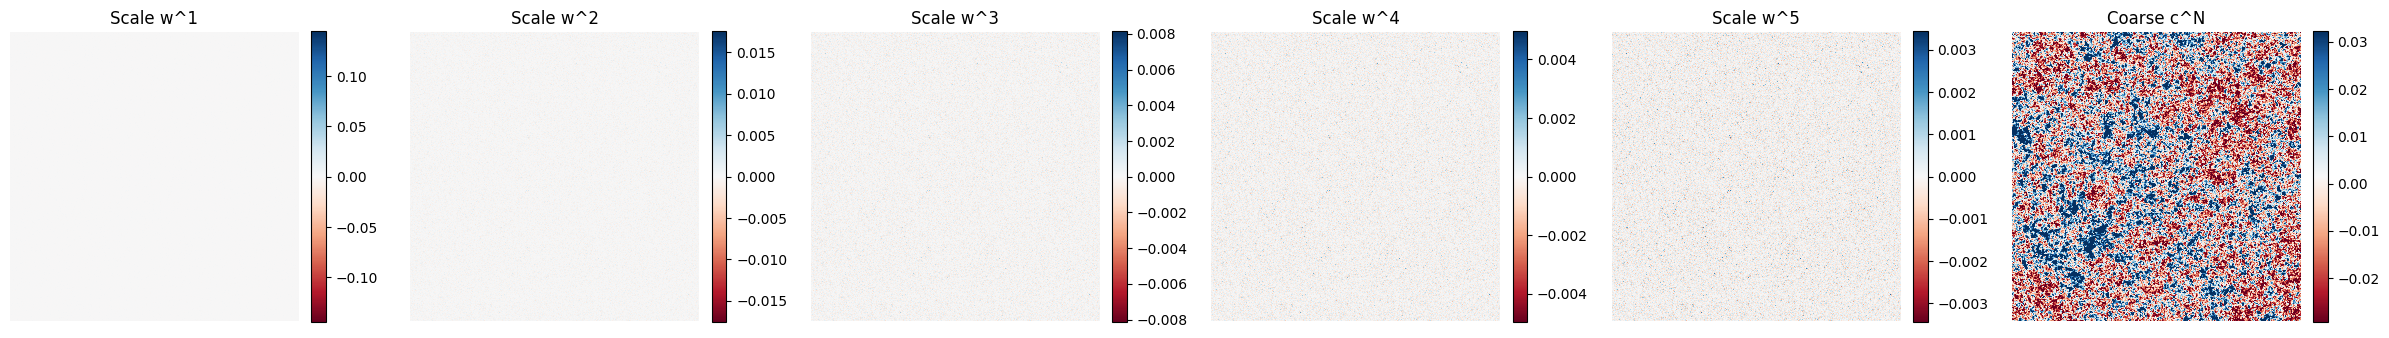

In [47]:
fig, axs = plt.subplots(1, n_scales + 1, figsize=(4*(n_scales+1), 4))
scale_labels = [f'Scale w^{i+1}' for i in range(n_scales)] + ['Coarse c^N']

for ax, data, lbl in zip(axs, coeffs, scale_labels):
    mean = np.mean(data)
    std = np.std(data)
    im = ax.imshow(data, origin='lower', cmap='RdBu', vmin=mean-std, vmax=mean+std)
    ax.set_title(lbl)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Gaussian Filter

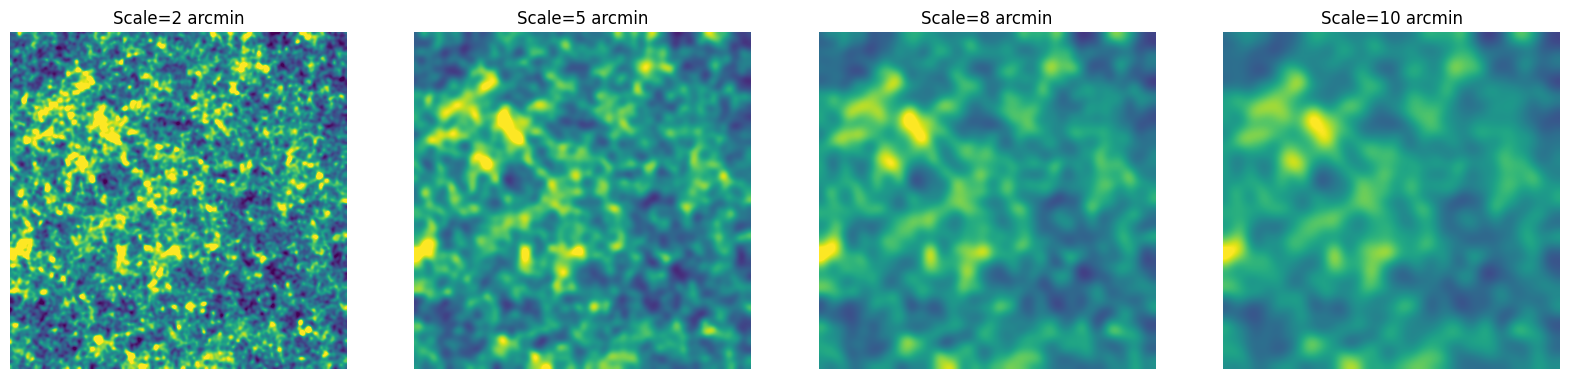

In [20]:
scales = [2, 5, 8, 10]  # in arcmin
filtered_patches = {}

fig, ax = plt.subplots(1, len(scales), figsize=(20, 5))

for i, scale in enumerate(scales):
    sigma = scale / resolution_arcmin  # convert scale to sigma
    filtered_patch = gaussian_filter(noisy_samplepatch, sigma=sigma)
    filtered_patches[scale] = filtered_patch
    
    # Plot the filtered result on each panel
    ax[i].imshow(filtered_patch, cmap="viridis", vmin=-0.032, vmax=0.032)
    ax[i].set_title(f"Scale={scale} arcmin")
    ax[i].axis('off')

plt.show()

# Wiener filter

In [36]:
kernel = 21
kernel_ft = fft2(kernel, s=noisy_samplepatch.shape)
snr = np.mean(np.abs(noisy_samplepatch)) / np.std(noisy_samplepatch)
H = np.conj(kernel_ft) / (np.abs(kernel_ft)**2 + 1/snr)
result = np.real(ifft2(fft_noisy_samplepatch * H))

ValueError: axes exceeds dimensionality of input

# Starlet filter

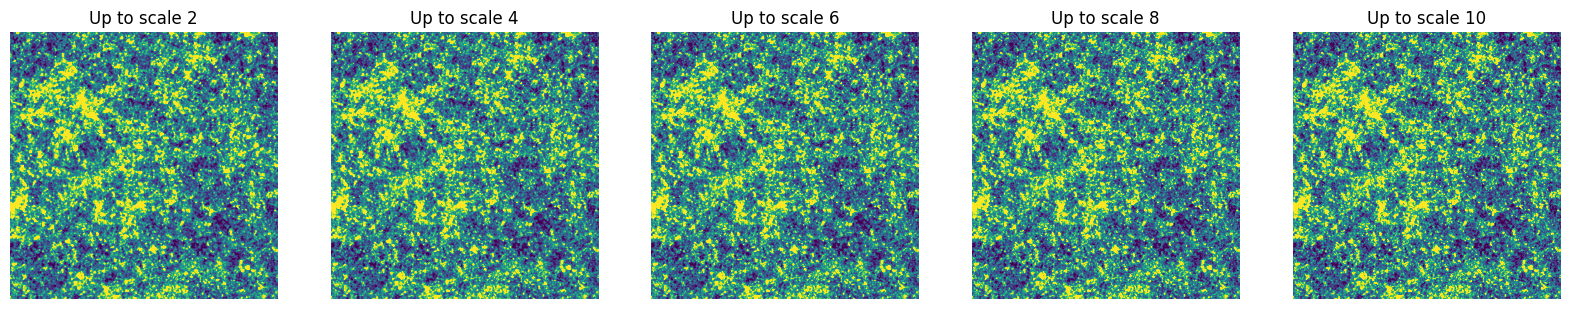

In [31]:
from scipy.ndimage import convolve1d

# Convert the FFT back to real space
starlet_input = np.fft.ifft2(fft_samplepatch).real

def starlet_transform(image, nscales=5):
    """
    Compute a simple starlet (isotropic wavelet) transform.
    Returns a list of wavelet scales plus the final coarse scale.
    """
    
    # B3-spline kernel
    h = np.array([1., 4., 6., 4., 1.]) / 16.
    c_current = image.copy()
    scales = []
    
    for _ in range(nscales):
        smooth = convolve1d(c_current, h, axis=0, mode='reflect')
        smooth = convolve1d(smooth, h, axis=1, mode='reflect')
        w = c_current - smooth
        scales.append(w)
        c_current = smooth
    
    scales.append(c_current)  # final coarse scale
    return scales

# Perform the starlet transform
starlet_coeffs = starlet_transform(starlet_input, nscales=16)

# Example: Reconstruct and display the patch up to different starlet scales
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i in range(1, 6):
    partial_reconstruction = sum(starlet_coeffs[:i*2]) + starlet_coeffs[-1]
    axes[i-1].imshow(partial_reconstruction, cmap='viridis', vmin=-0.032, vmax=0.032)
    axes[i-1].set_title(f"Up to scale {i*2}")
    axes[i-1].axis('off')

plt.show()